Unit 4 Incremental

Part 3 - Customer Reviews starter code

Matt Lucas - 2509

In this project, only concern yourself with reading the review title, the review text, and then have the model predict whether or not that was a good or a bad review.

This is a very hard project! The dataset is imbalanced, and your model would love to predict that all the reviews are positive. The NLP upcoming NLP and LLM modules and the provided capstone projects will give more practice and tools to improve sentiment analysis. Consider it a win if you can get your model to not be greedy (guess that all the reviews are positive/negative).

My model's confusion matrix was as follows:

[40  39

304 1526]

Results will vary, but what you don't want is all the numbers in the left column or all the numbers in the right column.

Imports

In [7]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "ATTACH YOUR FILE PATH"
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"
print("Using data file:", DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using data file: /content/drive/MyDrive/Colab Notebooks/KP_Capstones_and_End_Projects/Course_04 - Deep Learning with Tensorflow and Keras/GrammarandProductReviews.xlsx


To be able to read the excel file, you may need to use this in the terminal: pip install openpyxl

load the dataset and view the column names

In [9]:
df = pd.read_excel(DATA_PATH)
df.head()

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.025370e+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,Joshua,6.025370e+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,7.341600e+10,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,NaN,NaN,Dorothy W,7.341600e+10
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,7.341600e+10,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,NaN,NaN,Dorothy W,7.341600e+10
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,6.798193e+10,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,6.798193e+10
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,6.798193e+10,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,Walker557,6.798193e+10


I'm only going to use reviews.title, reviews.text, and reviews.rating.

In [10]:
data = df[["reviews.title", "reviews.text", "reviews.rating"]].copy()

data["text"] = (
    data["reviews.title"].astype(str) + " " +
    data["reviews.text"].astype(str)
)

data["rating"] = pd.to_numeric(
    data["reviews.rating"],
    errors="coerce"
)

Remove missing data

In [11]:
data = data[["text", "rating"]].copy()

data = data.dropna(subset=["text", "rating"]).reset_index(drop=True)
data.head()

,text,rating
0,Just Awesome i love this album. it's very good...,5
1,Good Good flavor. This review was collected as...,5
2,Good Good flavor.,5
3,Disappointed I read through the reviews on her...,1
4,Irritation My husband bought this gel for us. ...,1


Create a binary positive/negative for reviews. out of 5 stars, 2 and 1 are negative, 4 and 5 are positive. 3's are turned into n/a values and removed.

In [12]:
def rating_to_label(r: float) -> float:
    if r >= 4:
        return 1
    if r <= 2:
        return 0
    return np.nan


data["label"] = data["rating"].apply(rating_to_label)
data = data.dropna(subset=["label"]).reset_index(drop=True)
data["label"] = data["label"].astype(int)

some light data cleaning.

In [13]:
url_re = re.compile(r"https?://\S+|www\.\S+")
html_re = re.compile(r"<.*?>")

def clean_text(s: str) -> str:
    s = s.lower().strip()
    s = url_re.sub(" ", s)
    s = html_re.sub(" ", s)
    s = re.sub(r"[^a-z0-9\s\.,!?\'\"\-]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

data["text_clean"] = data["text"].map(clean_text)

Remove reviews that are too short

In [14]:
MIN_REVIEW_LENGTH = 3
before = len(data)
data = data[data["text_clean"].str.len() > MIN_REVIEW_LENGTH].reset_index(drop=True)
print(f"Removed {before - len(data)} reviews with {MIN_REVIEW_LENGTH} or fewer characters; remaining: {len(data)}")

Removed 0 reviews with 3 or fewer characters; remaining: 9548


Train/Test Split


In [15]:
X = data["text_clean"].values
y = data["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print("Train size:", len(X_train), "Test size:", len(X_test))
print("Training class distribution:")
print(pd.Series(y_train).value_counts().sort_index())

Train size: 7638 Test size: 1910
Training class distribution:
0     315
1    7323
Name: count, dtype: int64


As you can see, the training set is overwhelmingly positive.

## Tokenize and Pad Sequences


In [16]:
# Tokenize and pad sequences
# TODO: Set VOCAB_SIZE to 20000 and MAX_LEN to 200
VOCAB_SIZE = 20000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


# TODO: Convert texts to sequences for both training and test sets
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

# TODO: Pad sequences using pad_sequences
# Parameters: maxlen=MAX_LEN, padding="post", truncating="post"
X_train_pad = pad_sequences(train_seq, maxlen = MAX_LEN, padding = "post", truncating = "post")
X_test_pad = pad_sequences(test_seq, maxlen = MAX_LEN, padding = "post", truncating = "post")

print("Padded train shape:", X_train_pad.shape)
print("Padded test shape:", X_test_pad.shape)


Padded train shape: (7638, 200)
Padded test shape: (1910, 200)


## Apply Undersampling to Balance Classes

SMOTE is not a great way to balance this dataset because it is not numerical, there's no real way to synthetically create text reviews between the clusters.

**Resources for learning about undersampling:**
- [Handling Imbalanced Data for Classification - GeeksforGeeks](https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/) - Comprehensive guide on undersampling, oversampling, and other techniques for handling class imbalance
- [imbalanced-learn Documentation - RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html) - Official API documentation for RandomUnderSampler

In [18]:
# Apply undersampling to balance classes (1:3 ratio to keep more data)
print("\nApplying Random Undersampling with 1:3 ratio...")
print(f"Before undersampling: {X_train_pad.shape[0]} samples")
print("Class distribution before:")
print(pd.Series(y_train).value_counts().sort_index())

# Count minority class samples
# TODO: Count how many samples belong to the minority class (label 0)
minority_count = np.sum(y_train == 0)

# Calculate target for majority class (keep 3x the minority class)
# TODO: Set majority_target to be 3 times the minority_count
majority_target = minority_count * 3

print(f"\nMinority class (negative): {minority_count} samples")
print(f"Target majority class (positive): {majority_target} samples")
print(f"(Using 1:3 ratio instead of 1:1 to keep more training data)")

# Use undersampling with custom ratio
# TODO: Create a RandomUnderSampler with:
# - random_state=SEED
# - sampling_strategy={0: minority_count, 1: majority_target}
undersampler = RandomUnderSampler(
    random_state = SEED,
    sampling_strategy={0: minority_count, 1: majority_target}
)

# TODO: Apply fit_resample to X_train_pad and y_train
X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_pad, y_train)

print(f"\nAfter undersampling: {X_train_balanced.shape[0]} samples")
print("Class distribution after:")
print(pd.Series(y_train_balanced).value_counts().sort_index())



Applying Random Undersampling with 1:3 ratio...
Before undersampling: 7638 samples
Class distribution before:
0     315
1    7323
Name: count, dtype: int64

Minority class (negative): 315 samples
Target majority class (positive): 945 samples
(Using 1:3 ratio instead of 1:1 to keep more training data)

After undersampling: 1260 samples
Class distribution after:
0    315
1    945
Name: count, dtype: int64


Build the model

In [22]:
# Build CNN-LSTM hybrid model
# TODO: Set EMBED_DIM to 100 (embedding dimension for word vectors)
EMBED_DIM = 100

# TODO: Build a Sequential model with the following layers:
# 1. Embedding layer: input_dim=VOCAB_SIZE, output_dim=EMBED_DIM
# 2. Conv1D layer: filters=64, kernel_size=5, activation='relu'
# 3. MaxPooling1D layer: pool_size=2
# 4. Dropout layer: rate=0.3
# 5. LSTM layer: units=32, return_sequences=False
# 6. Dropout layer: rate=0.3
# 7. Dense layer: units=32, activation='relu'
# 8. Dropout layer: rate=0.3
# 9. Dense output layer: units=1, activation='sigmoid'
model = models.Sequential([
    layers.Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_DIM),
    layers.Conv1D(filters = 64, kernel_size = 5, activation = "relu"),
    layers.MaxPooling1D(pool_size = 2),
    layers.Dropout(0.3),
    layers.LSTM(units = 32, return_sequences = False),
    layers.Dropout(0.3),
    layers.Dense(units = 32, activation = "relu"),
    layers.Dropout(0.3),
    layers.Dense(units = 1, activation = "sigmoid"),
])

# TODO: Compile the model with:
# - optimizer: tf.keras.optimizers.Adam(learning_rate=0.0005)
# - loss: 'binary_crossentropy'
# - metrics: ['accuracy']
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [23]:

BATCH_SIZE = 32
EPOCHS = 30

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,  # Increased patience
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,  # Increased patience
        min_lr=1e-7,
        verbose=1
    ),
    # Add ModelCheckpoint to save best model
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=0
    )
]

# Split balanced data for validation
from sklearn.model_selection import train_test_split as sk_split
X_train_final, X_val_final, y_train_final, y_val_final = sk_split(
    X_train_balanced, y_train_balanced,
    test_size=0.2,
    random_state=SEED,
    stratify=y_train_balanced
)

print(f"Training on balanced data: {len(X_train_final)} samples")
print(f"Validation: {len(X_val_final)} samples")
print(f"Training class distribution:")
print(pd.Series(y_train_final).value_counts().sort_index())

# Add moderate class weights based on the balanced training data
# Since we're using 1:3 ratio, adjust weights accordingly
classes = np.array([0, 1])
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_balanced)
# Moderate weighting - cap at 2.0 to prevent over-weighting (reduced from 2.5)
class_weight = {0: min(float(weights[0]), 2.0), 1: 1.0}
print(f"\nUsing class weights: {class_weight}")
print("(Moderate weight on negative class - capped at 2.0 to prevent extreme bias)")
print("\nNote: Model architecture simplified to help learn better class distinctions")

history = model.fit(
    X_train_final,
    y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,  # Add class weights for extra emphasis
    callbacks=callbacks,
    verbose=1,
)


Training on balanced data: 1008 samples
Validation: 252 samples
Training class distribution:
0    252
1    756
Name: count, dtype: int64

Using class weights: {0: 2.0, 1: 1.0}
(Moderate weight on negative class - capped at 2.0 to prevent extreme bias)

Note: Model architecture simplified to help learn better class distinctions
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7469 - loss: 0.8463

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.7470 - loss: 0.8463 - val_accuracy: 0.7500 - val_loss: 0.6014 - learning_rate: 5.0000e-04
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.7538 - loss: 0.8452 - val_accuracy: 0.7500 - val_loss: 0.6230 - learning_rate: 5.0000e-04
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.7538 - loss: 0.8404 - val_accuracy: 0.7500 - val_loss: 0.6116 - learning_rate: 5.0000e-04
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7542 - loss: 0.8380 - val_accuracy: 0.7500 - val_loss: 0.6082 - learning_rate: 5.0000e-04
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.7556 - loss: 0.8399 - val_accuracy: 0.7500 - val_loss: 0.6158 - learning_rate: 5.0000e-04
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7622 - loss: 0.8389
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.7620 - loss: 0

Evaluate the Model

NOTE: check the confusion matrix to ensure that all the values are not either all positive or all negative. If they are all on one side, your model is getting greedy. You'll want to tinker with the model to get it to try to learn both positive and negative sentiments.

TRAINING HISTORY SUMMARY
Final Training Loss: 0.8379, Accuracy: 0.7550
Final Validation Loss: 0.6085, Accuracy: 0.7579
Loss improvement: 0.0106

TEST SET EVALUATION
Test Loss: 0.5063
Test Accuracy: 0.9586

Probability Statistics:
Mean: 0.6145
Min: 0.5236, Max: 0.6152
Std: 0.0071
⚠️  WARNING: Probabilities are too clustered - model may not be learning!

ROC AUC Score: 0.6728

Threshold Selection:
  Youden's J (max TPR-FPR): 0.6152
  F1-score optimal: 0.5236 (F1 = 0.9789)

Comparison:
  Youden's threshold: Precision=0.973, Recall=0.852, F1=0.908
  F1-optimal threshold: Precision=0.959, Recall=1.000, F1=0.979

⚠️  F1-optimal threshold (0.5236) causes all predictions to be positive!
   Using Youden's J threshold (0.6152) instead for better balance.

CONFUSION MATRIX
                     Predicted: Negative       Predicted: Positive      
Actual: Negative     TN=35                     FP=44                    
Actual: Positive     FN=271                    TP=1560                  

📊 KEY M

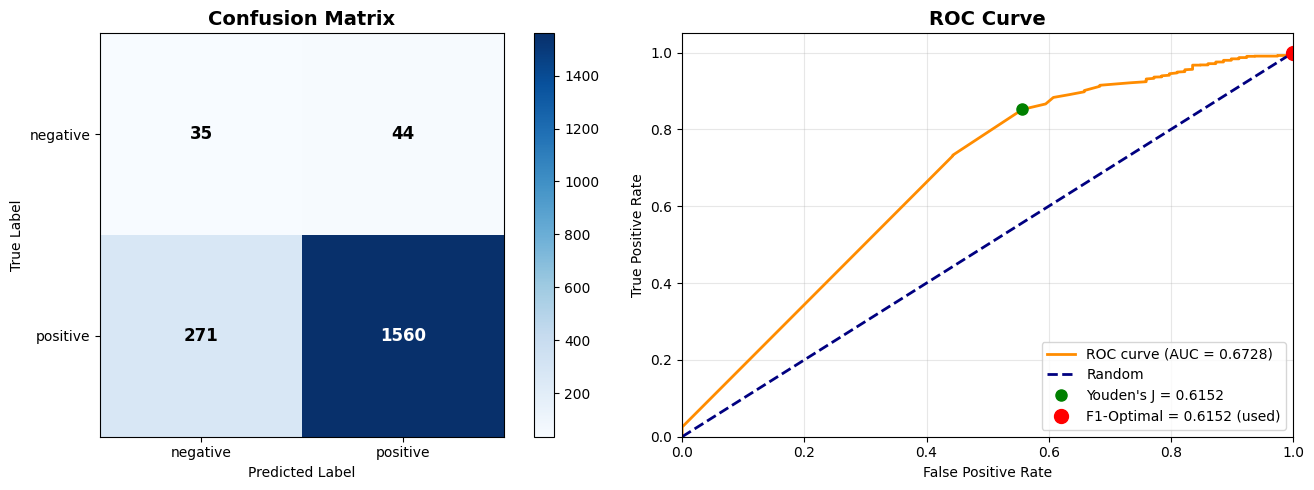

In [24]:
# 9) Evaluate

# First, check training history to ensure model learned
print("="*60)
print("TRAINING HISTORY SUMMARY")
print("="*60)
if 'loss' in history.history:
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    print(f"Final Training Loss: {final_train_loss:.4f}, Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}, Accuracy: {final_val_acc:.4f}")

    # Check if model improved
    if len(history.history['loss']) > 1:
        initial_loss = history.history['loss'][0]
        loss_improvement = initial_loss - final_train_loss
        print(f"Loss improvement: {loss_improvement:.4f}")
        if loss_improvement < 0.01:
            print("⚠️  WARNING: Model may not be learning (minimal loss improvement)")

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

# Evaluate loss + accuracy
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predict probabilities
y_prob = model.predict(X_test_pad, verbose=0).ravel()

# ---- Sanity check on probabilities FIRST ----
print("\nProbability Statistics:")
print(f"Mean: {np.mean(y_prob):.4f}")
print(f"Min: {np.min(y_prob):.4f}, Max: {np.max(y_prob):.4f}")
print(f"Std: {np.std(y_prob):.4f}")

# Check if probabilities are too clustered (model not learning)
if np.std(y_prob) < 0.01:
    print("⚠️  WARNING: Probabilities are too clustered - model may not be learning!")

# ---- Find optimal threshold using multiple methods ----
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Method 1: Youden's J statistic (maximizes TPR - FPR)
youden_j = tpr - fpr
optimal_idx_youden = np.argmax(youden_j)
optimal_threshold_youden = thresholds[optimal_idx_youden]

# Method 2: F1-score optimization (better for imbalanced data)
f1_scores = []
for threshold in thresholds:
    y_pred_temp = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_temp, zero_division=0)
    f1_scores.append(f1)

optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = thresholds[optimal_idx_f1]
max_f1 = f1_scores[optimal_idx_f1]

print(f"\nROC AUC Score: {roc_auc:.4f}")
if roc_auc < 0.5:
    print("⚠️  WARNING: ROC AUC < 0.5 means model is worse than random!")
elif roc_auc < 0.6:
    print("⚠️  WARNING: ROC AUC < 0.6 means model performance is poor")

print(f"\nThreshold Selection:")
print(f"  Youden's J (max TPR-FPR): {optimal_threshold_youden:.4f}")
print(f"  F1-score optimal: {optimal_threshold_f1:.4f} (F1 = {max_f1:.4f})")

# Compare both thresholds
y_pred_youden = (y_prob >= optimal_threshold_youden).astype(int)
y_pred_f1 = (y_prob >= optimal_threshold_f1).astype(int)

f1_youden = f1_score(y_test, y_pred_youden, zero_division=0)
recall_youden = recall_score(y_test, y_pred_youden, zero_division=0)
precision_youden = precision_score(y_test, y_pred_youden, zero_division=0)

f1_f1 = f1_score(y_test, y_pred_f1, zero_division=0)
recall_f1 = recall_score(y_test, y_pred_f1, zero_division=0)
precision_f1 = precision_score(y_test, y_pred_f1, zero_division=0)

print(f"\nComparison:")
print(f"  Youden's threshold: Precision={precision_youden:.3f}, Recall={recall_youden:.3f}, F1={f1_youden:.3f}")
print(f"  F1-optimal threshold: Precision={precision_f1:.3f}, Recall={recall_f1:.3f}, F1={f1_f1:.3f}")

# Choose threshold intelligently - avoid extreme values
# If F1-optimal is too extreme (< 0.4 or > 0.7), use Youden's J instead
# Also check if F1-optimal causes all predictions to be one class
THRESHOLD_MIN = 0.4  # Increased from 0.3 to be more conservative
THRESHOLD_MAX = 0.7

# Check if F1-optimal threshold causes all predictions to be one class
all_positive_f1 = np.all(y_pred_f1 == 1)
all_negative_f1 = np.all(y_pred_f1 == 0)

if optimal_threshold_f1 < THRESHOLD_MIN or optimal_threshold_f1 > THRESHOLD_MAX:
    print(f"\n⚠️  F1-optimal threshold ({optimal_threshold_f1:.4f}) is too extreme!")
    print(f"   Using Youden's J threshold ({optimal_threshold_youden:.4f}) instead for better balance.")
    optimal_threshold = optimal_threshold_youden
    y_pred = y_pred_youden
elif all_positive_f1 or all_negative_f1:
    print(f"\n⚠️  F1-optimal threshold ({optimal_threshold_f1:.4f}) causes all predictions to be {'positive' if all_positive_f1 else 'negative'}!")
    print(f"   Using Youden's J threshold ({optimal_threshold_youden:.4f}) instead for better balance.")
    optimal_threshold = optimal_threshold_youden
    y_pred = y_pred_youden
else:
    print(f"\n✅ Using F1-optimal threshold: {optimal_threshold_f1:.4f}")
    optimal_threshold = optimal_threshold_f1
    y_pred = y_pred_f1

# ---- Confusion Matrix + Report ----
cm = confusion_matrix(y_test, y_pred)

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n" + "="*60)
print("CONFUSION MATRIX")
print("="*60)
print(f"{'':20s} {'Predicted: Negative':25s} {'Predicted: Positive':25s}")
print(f"{'Actual: Negative':20s} {f'TN={tn}':25s} {f'FP={fp}':25s}")
print(f"{'Actual: Positive':20s} {f'FN={fn}':25s} {f'TP={tp}':25s}")
print("="*60)

print(f"\n📊 KEY METRICS:")
print(f"  Precision: {precision:.4f} (of predicted positive, how many are actually positive)")
print(f"  Recall (Sensitivity): {recall:.4f} (of actual positive, how many did we catch)")
print(f"  Specificity: {specificity:.4f} (of actual negative, how many did we correctly identify)")
print(f"  F1-Score: {f1:.4f} (harmonic mean of precision and recall)")
print(f"  False Negatives: {fn} (missed positive reviews - we want to minimize this)")
print(f"  False Positives: {fp} (incorrectly flagged as positive)")

print(
    "\nClassification Report:\n",
    classification_report(
        y_test,
        y_pred,
        target_names=["negative", "positive"],
        zero_division=0
    )
)

# ---- Confusion Matrix Visualization ----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
im = ax1.imshow(cm, cmap='Blues')
ax1.figure.colorbar(im, ax=ax1)
ax1.set_title("Confusion Matrix", fontsize=14, fontweight='bold')
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(["negative", "positive"])
ax1.set_yticklabels(["negative", "positive"])
ax1.set_xlabel("Predicted Label")
ax1.set_ylabel("True Label")

# Annotate each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontweight='bold', fontsize=12)

# ROC Curve with both threshold markers
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
# Mark Youden's optimal
ax2.plot(fpr[optimal_idx_youden], tpr[optimal_idx_youden], 'go', markersize=8,
         label=f"Youden's J = {optimal_threshold_youden:.4f}")
# Mark F1-optimal
ax2.plot(fpr[optimal_idx_f1], tpr[optimal_idx_f1], 'ro', markersize=10,
         label=f'F1-Optimal = {optimal_threshold:.4f} (used)')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Plot the Training History

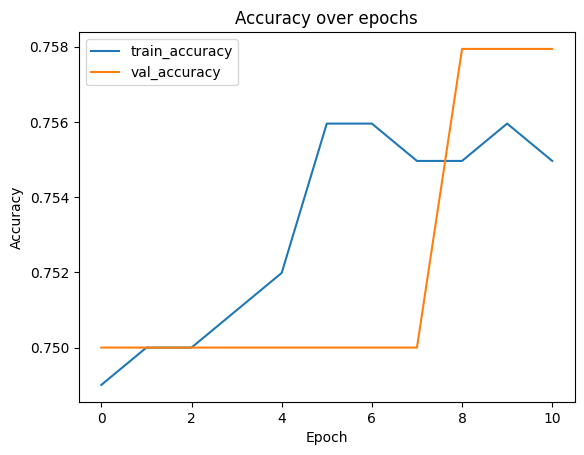

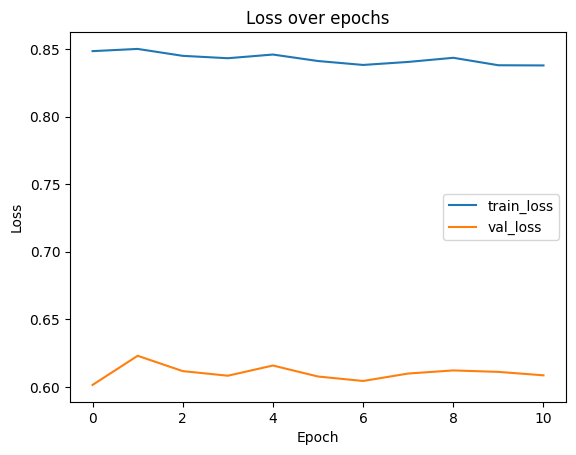

In [25]:
# 10) (Optional) Plot training history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history.get("accuracy", []), label="train_accuracy")
plt.plot(history.history.get("val_accuracy", []), label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

plt.figure()
plt.plot(history.history.get("loss", []), label="train_loss")
plt.plot(history.history.get("val_loss", []), label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over epochs")
plt.show()


Questions to answer:

Was the model greedy? What did you try to get it to check for both values?

Compare this binary (positive or negative) To the NLP we just learned.